In [2]:
from torchvision import transforms
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
import torch
import numpy as np
import time
import matplotlib.pyplot as plt

In [3]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

In [4]:
train_dataset = MNIST('.', train=True, download=True, transform=transform)
test_dataset = MNIST('.', train=False, transform=transform)

Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw


Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw


Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw


Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:469: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [5]:
#фильтруем фичи (дата) по значению классификационных лэйблов (таргет), берем или цифру 3 или цифру 7
train_dataset.data = train_dataset.data[(train_dataset.targets == 3) | (train_dataset.targets == 7)]
train_dataset.targets = train_dataset.targets[(train_dataset.targets == 3) | (train_dataset.targets == 7)]
#тоже самое для тестового набора
test_dataset.data = test_dataset.data[(test_dataset.targets == 3) | (test_dataset.targets == 7)]
test_dataset.targets = test_dataset.targets[(test_dataset.targets == 3) | (test_dataset.targets == 7)]
#необходимы препроцессинг лейблов, видимо не все значения имею тип integer, а нам нужен именно этот тип функция лонг позволяет нам 
#        это сделать (self.long() is equivalent to self.to(torch.int64). See to())
train_dataset.targets = (train_dataset.targets == 7).long()
test_dataset.targets = (test_dataset.targets == 7).long()

In [6]:
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

In [7]:
X, y = next(iter(train_loader))
X = X.view(X.shape[0], -1)
X.shape, y.shape

(torch.Size([128, 784]), torch.Size([128]))

In [8]:
X.shape, y.shape

(torch.Size([128, 784]), torch.Size([128]))

In [9]:
w = torch.rand(784, 1) #Рандомные необученые веса
pred = X.matmul(w)
pred.shape

torch.Size([128, 1])

In [10]:
y = np.expand_dims(y, 1)
y.shape

(128, 1)

# Двухслойный перцептрон 

In [11]:
learning_rate = 0.01
epochs = 3

batch_size = 128
n_feat = 784

w1 = np.random.rand(n_feat,100)*0.01
b1 = np.zeros(100)
w2 = np.random.rand(100,1)*0.01
b2 = np.zeros(1)

losses = []

for n_epoch in range(epochs):
    
    print(f'Epoch: {n_epoch + 1}')
    
    for x, y in train_loader:
        
        # forward
        x = x.view(x.shape[0], -1).numpy() # приводим к размерности (128,784)
        y = np.expand_dims(y.numpy(), 1) # приводим к размерности (128,1)
        
        z1 = x.dot(w1) + b1 # переход в 100-мерное пространство
        a1 = 1/(1+np.exp(-z1)) # сигмоида

        z2 = a1.dot(w2) + b2 # переход в одномерное пространство
        p = 1/(1+np.exp(-z2)) # prediction

        # рассчет bce
        bce = (-np.sum(np.multiply(np.log(p), y) + np.multiply((1 - y), np.log(1 - p)))) / batch_size 
        losses.append(bce)

        # backward
        # градиент функции потерь по pred - (BATCH_SIZE, 1)
        dbce_dp = (p - y) / batch_size
        #print(dbce_dp.shape)

        # градиент нелинейной функции по z1 - (BATCH_SIZE, INNER_FEATURES)
        da1_dz1 = 1 - ((np.exp(z1) - np.exp(-z1))/(np.exp(z1) + np.exp(-z1)))
        #print(da1_dz1.shape)
        
        # градиент линейного преобразования по w2 - (INNER_FEATURES, 1)
        dw2 = (np.dot(a1.T, dbce_dp))
        #print(dw2.shape)
        
        # градиент линейного преобразования по b2 - (1,)
        db2 = np.sum(dbce_dp)
        #print(db2.shape)

        #градиент линейного преобразования по w1 - (IN_FEATURES, INNER_FEATURES)
        dw1 = np.dot(x.T, np.multiply(dbce_dp, np.multiply(w2.T, da1_dz1)))
        #print(dw1.shape)

        #градиент линейного преобразования по b1 - (INNER_FEATURES,)
        db1 = np.dot(np.ones(shape=(x.shape[0])), np.multiply(dbce_dp, np.multiply(w2.T, da1_dz1)))
        #print(db1.shape)
        
        # gradient descent
        w2 -= learning_rate * dw2
        b2 -= learning_rate * db2
        w1 -= learning_rate * dw1
        b1 -= learning_rate * db1

Epoch: 1
Epoch: 2
Epoch: 3


# График

Text(0, 0.5, 'Loss function')

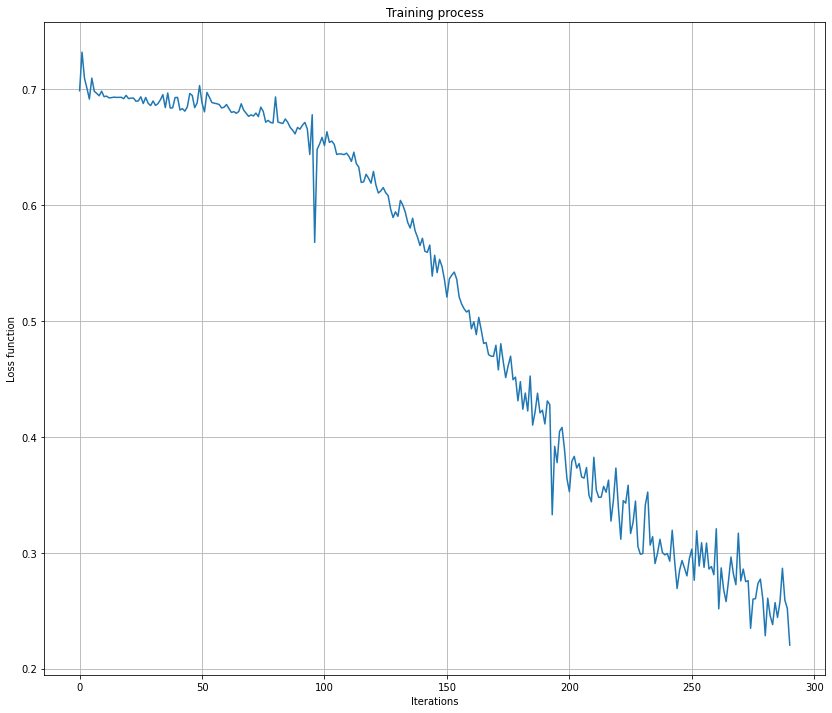

In [12]:
plt.figure(figsize=(14, 12))
plt.plot(losses)
plt.grid()
plt.title('Training process')
plt.xlabel('Iterations')
plt.ylabel('Loss function')

# Тестирование

In [14]:
losses_test = []
predicted = []
true_lbls = []


for x, y in test_loader:
    x = x.view(x.shape[0], -1).numpy() # приводим к размерности (128,784)
    y = np.expand_dims(y.numpy(), 1) # приводим к размерности (128,1)
    
    z1 = x.dot(w1) + b1 # переход в 100-мерное пространство
    a1 = 1/(1+np.exp(-z1)) # сигмоида
    
    z2 = a1.dot(w2) + b2 # переход в одномерное пространство
    p = 1/(1+np.exp(-z2)) # prediction

    # рассчет bce
    bce = (-np.sum(np.multiply(np.log(p), y) + np.multiply((1 - y), np.log(1 - p)))) / batch_size 
    losses_test.append(bce)
    predicted.extend(p)
    true_lbls.extend(y) 

In [15]:
print(len(predicted), len(true_lbls))

2038 2038


In [16]:
from sklearn.metrics import f1_score
pred = np.array([round(i[0]) for i in predicted]) 
t_lbls = np.array(true_lbls).squeeze()
f1 = f1_score(pred, t_lbls, average='weighted')
print('F1 score is equal to: {0:0.02f}'.format(f1))

F1 score is equal to: 0.96
